In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/varun/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray', '-I/home/varun/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda', '-I/home/varun/anaconda2/lib/python2.7/site-packages/numpy/core/include', '-I/home/varun/anaconda2/include/python2.7', '-I/home/varun/anaconda2/lib/python2.7/site-packages/theano/gof', '-o', '/home/varun/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-L/home/varun/anaconda2/lib', '-lcublas', '-lpython2.7', '-lcudart']


/home/varun/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/varun/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def load_dataset():
    url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    if not os.path.exists(filename):
        print("Downloading MNIST dataset...")
        urlretrieve(url, filename)
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    X_train, y_train = data[0]
    X_val, y_val = data[1]
    X_test, y_test = data[2]
    X_train = X_train.reshape((-1, 1, 28, 28))
    X_val = X_val.reshape((-1, 1, 28, 28))
    X_test = X_test.reshape((-1, 1, 28, 28))
    y_train = y_train.astype(np.uint8)
    y_val = y_val.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    return X_train, y_train, X_val, y_val, X_test, y_test

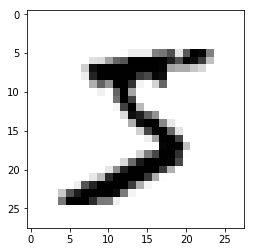

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
plt.imshow(X_train[0][0], cmap=cm.binary)

In [5]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 28, 28),
    # layer conv2d1
    conv2d1_num_filters=32,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=10,
    verbose=1,
    )
# Train the network
nn = net1.fit(X_train, y_train)

/home/varun/anaconda2/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 160362 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x28x28
  1  conv2d1   32x24x24
  2  maxpool1  32x12x12
  3  conv2d2   32x8x8
  4  maxpool2  32x4x4
  5  dropout1  32x4x4
  6  dense     256
  7  dropout2  256
  8  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.81731     0.15541    5.25916      0.95442  74.23s
      2     0.25978     0.10641    2.44138      0.96722  75.62s
      3     0.19189     0.08618    2.22671      0.97431  55.80s
      4     0.16012     0.07197    2.22486      0.97811  37.51s
      5     0.13275     0.06307    2.10462      0.98031  37.51s
      6     0.12135     0.05812    2.08770      0.98241  37.54s
      7     0.11062     0.05249    2.10730      0.98431  38.12s
      8     0.09858     0.05014    1.96617      0.98551  37.53s
      9     0.09477     0.04734    2.00195      0.98

In [6]:
preds = net1.predict(X_test)
print preds

[7 2 1 ..., 4 5 6]


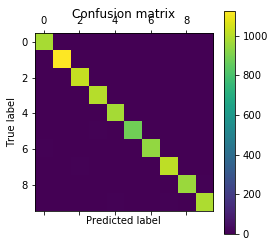

In [7]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<module 'matplotlib.pyplot' from '/home/varun/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

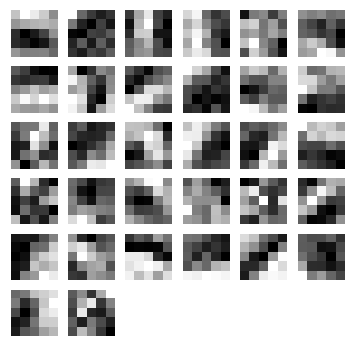

In [8]:
visualize.plot_conv_weights(net1.layers_['conv2d1'])

<module 'matplotlib.pyplot' from '/home/varun/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

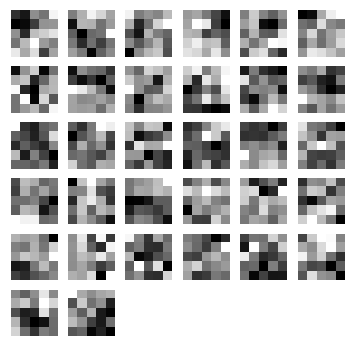

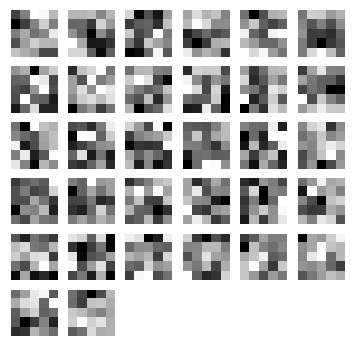

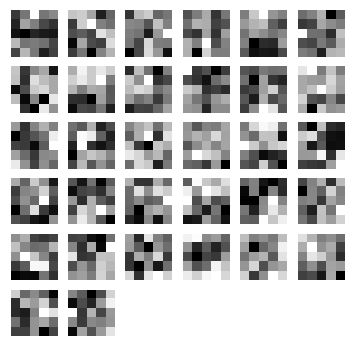

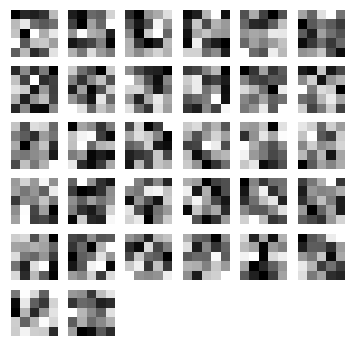

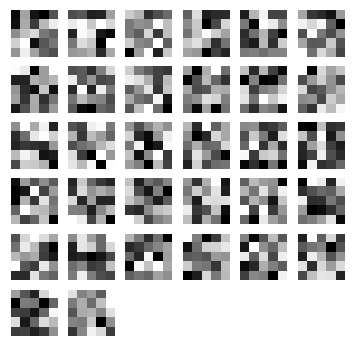

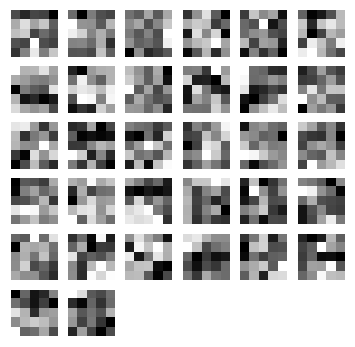

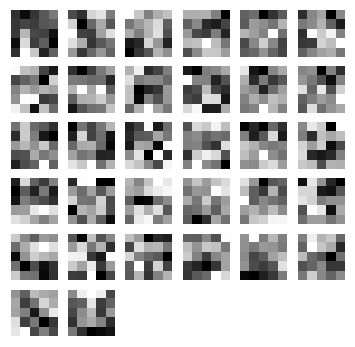

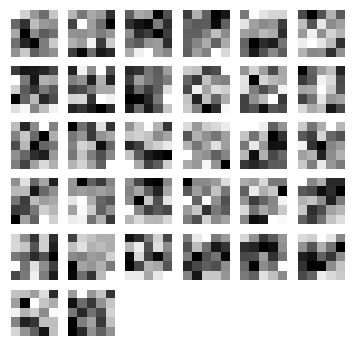

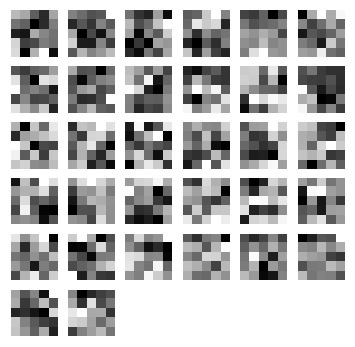

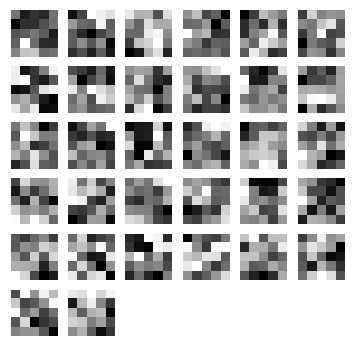

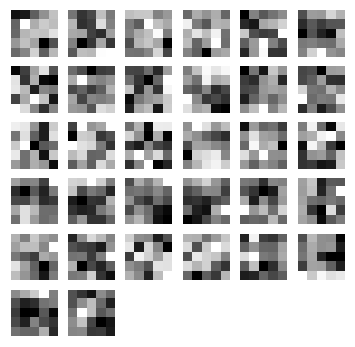

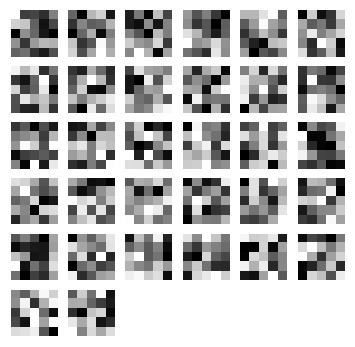

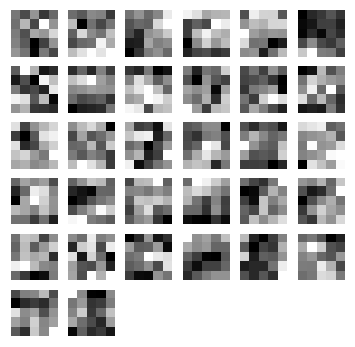

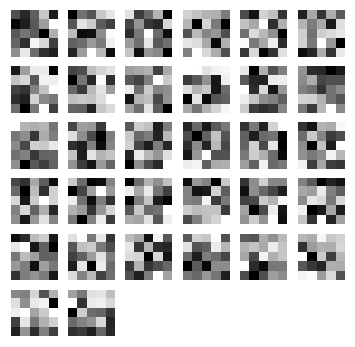

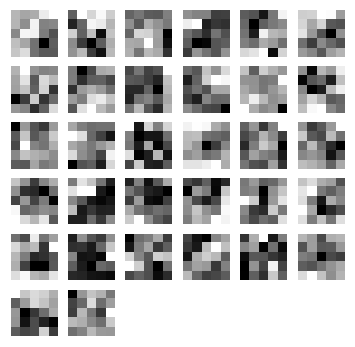

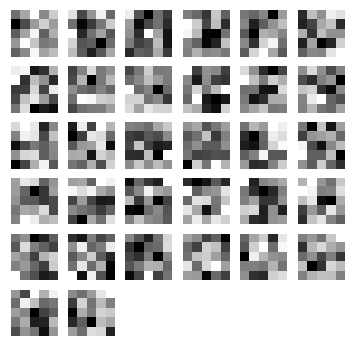

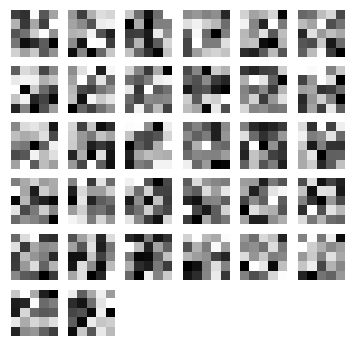

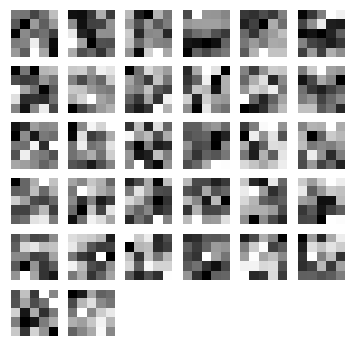

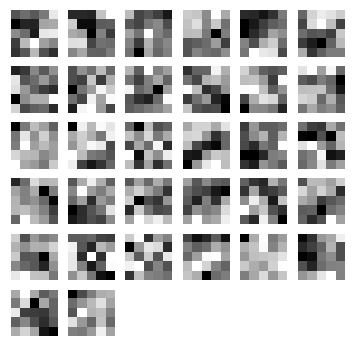

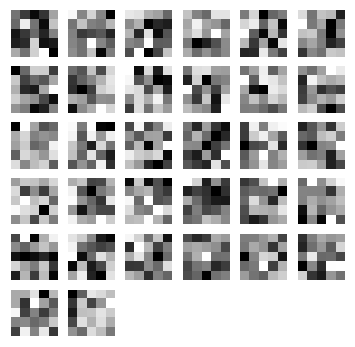

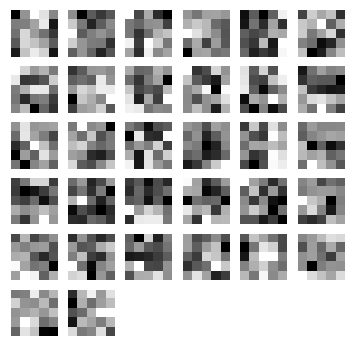

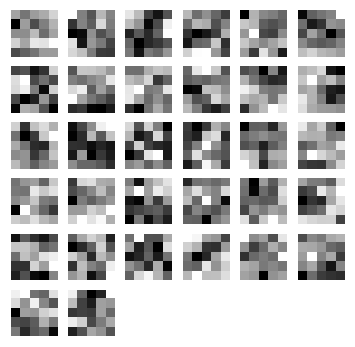

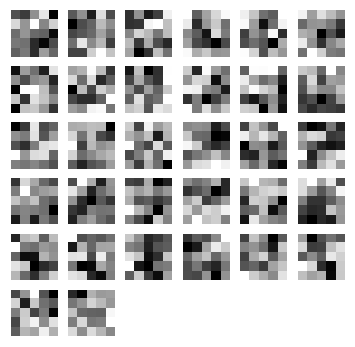

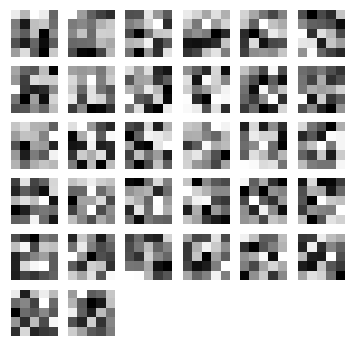

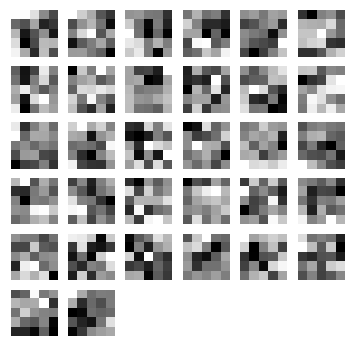

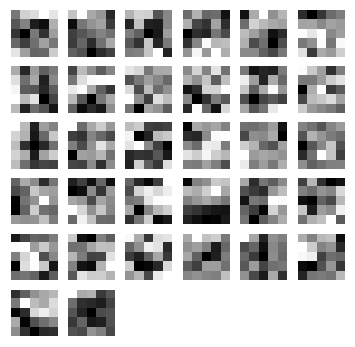

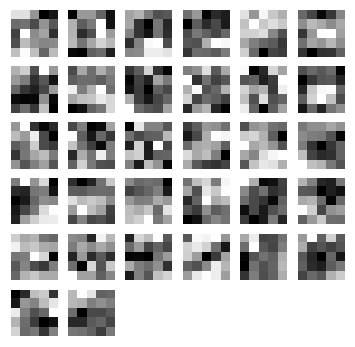

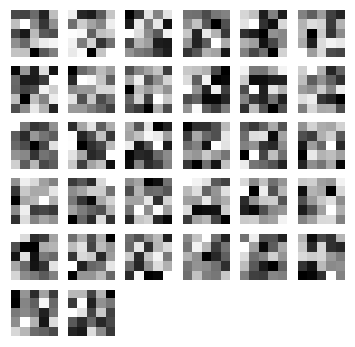

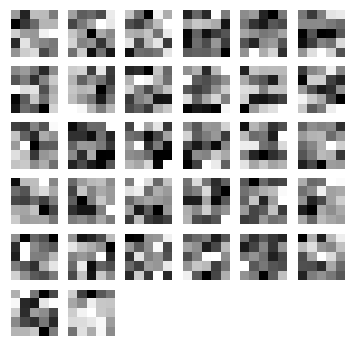

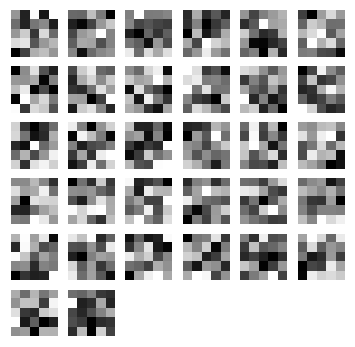

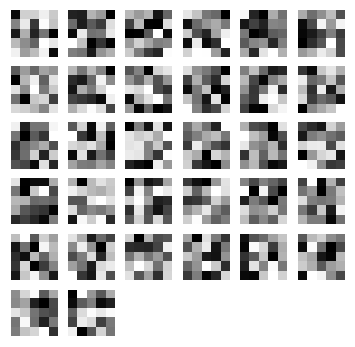

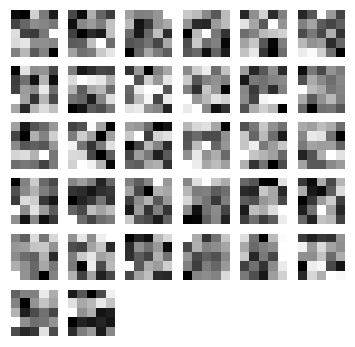

In [22]:
visualize.plot_conv_weights(net1.layers_['conv2d2'])

In [13]:
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

In [29]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)
#500 loops, best of 3: 858 µs per loop

500 loops, best of 3: 357 µs per loop


<Container object of 10 artists>

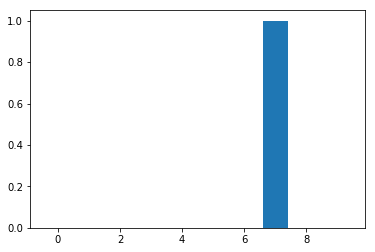

In [33]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

<Container object of 256 artists>

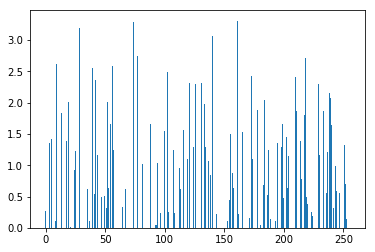

In [19]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())